In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pyrosm
import folium
from folium import plugins
from folium.plugins import HeatMap
from datetime import datetime

#call the function new_clean_data from the file data_cleaning.py
from data_cleaning import new_clean_data

In [3]:
# Dataset einlesen
data = new_clean_data(r'C:\Users\yasin\OneDrive\Desktop\DDT_Daten\bluebikes_2017_2018')

# Spaltennamen anzeigen
print(data.columns)



Index(['start_time', 'end_time', 'start_station_id', 'end_station_id',
       'bike_id', 'weekday'],
      dtype='object')


1. Station Utilization: Calculate the number of bike pickups and drop-offs at each station to determine the overall utilization of each docking station. This information can help identify stations that are consistently busy or underutilized.

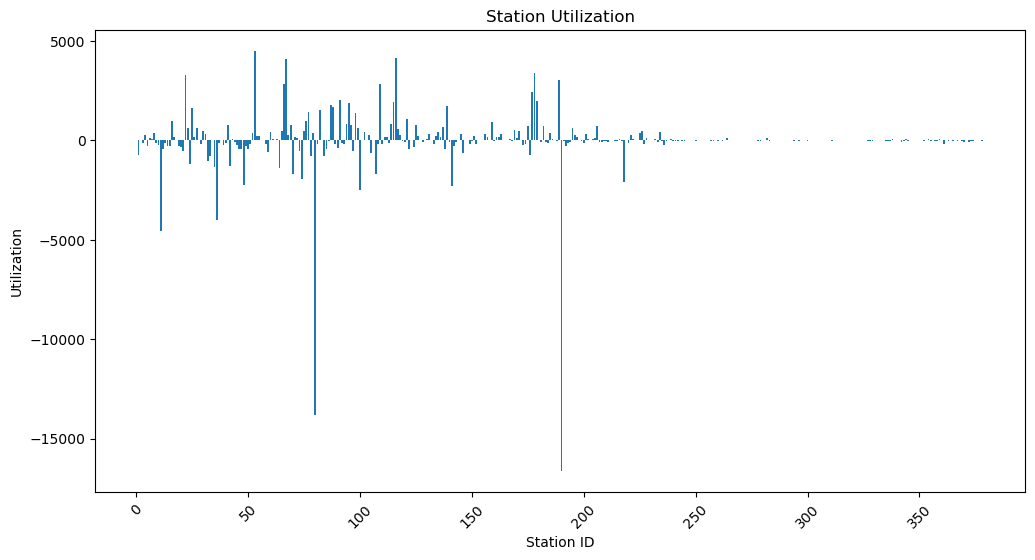

In [4]:
# Anzahl der Fahrradabholungen pro Station berechnen
pickup_counts = data['start_station_id'].value_counts()

# Anzahl der Fahrradrückgaben pro Station berechnen
dropoff_counts = data['end_station_id'].value_counts()

# Gesamte Auslastung pro Station berechnen (Abholungen - Rückgaben)
utilization = pickup_counts - dropoff_counts

# Diagramm zur Stationenauslastung anzeigen
plt.figure(figsize=(12, 6))
plt.bar(utilization.index, utilization.values)
plt.xlabel('Station ID')
plt.ylabel('Utilization')
plt.title('Station Utilization')
plt.xticks(rotation=45)
plt.show()

Angepasster Code:

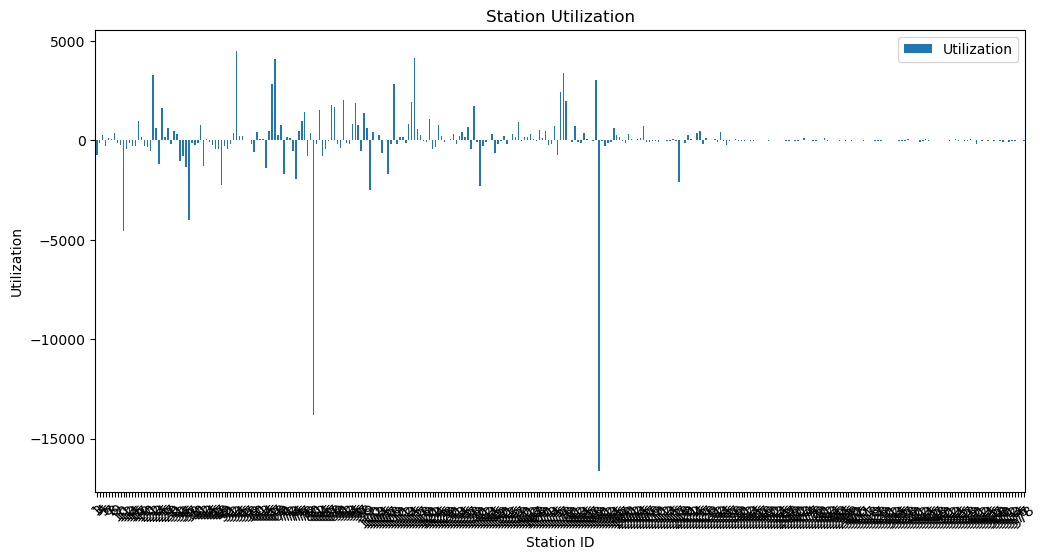

In [5]:
# Anzahl der Fahrradabholungen pro Station berechnen
pickup_counts = data['start_station_id'].value_counts()

# Anzahl der Fahrradrückgaben pro Station berechnen
dropoff_counts = data['end_station_id'].value_counts()

# Stationen in einem eindeutigen Set zusammenführen
stations = set(data['start_station_id'].unique()) | set(data['end_station_id'].unique())

# Auslastung für jede Station berechnen
utilization = {}
for station in stations:
    pickups = pickup_counts.get(station, 0)
    dropoffs = dropoff_counts.get(station, 0)
    utilization[station] = pickups - dropoffs

# Auslastung in einem DataFrame speichern
utilization_df = pd.DataFrame.from_dict(utilization, orient='index', columns=['Utilization'])

# Diagramm zur Stationenauslastung anzeigen
plt.figure(figsize=(12, 6))
utilization_df.plot(kind='bar', ax=plt.gca())
plt.xlabel('Station ID')
plt.ylabel('Utilization')
plt.title('Station Utilization')
plt.xticks(rotation=45)
plt.show()

In [8]:
# Umwandlung der Start- und Endzeit in das Datumsformat
data['start_time'] = pd.to_datetime(data['start_time'])
data['end_time'] = pd.to_datetime(data['end_time'])

# Berechnung der Fahrraddauer in Minuten
data['duration'] = (data['end_time'] - data['start_time']).mean()

# Durchschnittliche Fahrraddauer berechnen
average_duration = data['duration'].mean()

# Ausgabe der durchschnittlichen Fahrraddauer
print("Durchschnittliche Fahrraddauer:", average_duration, "Minuten")

Durchschnittliche Fahrraddauer: 0 days 00:23:17.623741140 Minuten


2. Popular Stations: Identify the stations with the highest number of bike rentals or the most frequent usage. These stations can be considered popular and may require additional resources or infrastructure to accommodate the demand.


In [26]:
# Die am häufigsten genutzten Startstationen ermitteln
grouped_data = data.groupby(['start_station_id'])
start_station_usage = grouped_data.size().reset_index(name='count')
start_station_usage


popular_start_stations = data['start_station_id'].value_counts().nlargest(10)

# Die am häufigsten genutzten Zielstationen ermitteln
popular_end_stations = data['end_station_id'].value_counts().nlargest(10)

# Ausgabe der Ergebnisse
print("Top 10 am häufigsten genutzte Startstationen:")
print(popular_start_stations)
print("\nTop 10 am häufigsten genutzte Zielstationen:")
print(popular_end_stations)







Top 10 am häufigsten genutzte Startstationen:
67     96165
80     66090
22     64188
68     63759
189    52368
178    48919
74     48105
190    47082
36     44610
53     44564
Name: start_station_id, dtype: int64

Top 10 am häufigsten genutzte Zielstationen:
67     92077
80     79886
190    63711
68     63500
22     60875
74     50044
189    49335
36     48588
178    45537
107    42470
Name: end_station_id, dtype: int64


3. Stations with High Demand: Analyze the stations to identify those with consistently high demand, especially during peak hours or on specific days of the week. This information can help in allocating more bikes to these stations and managing their capacity effectively.

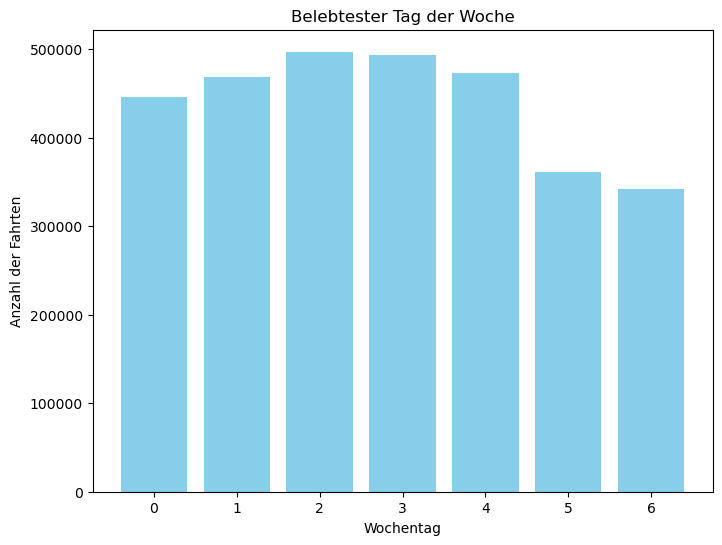

In [30]:
# Anzahl der Fahrten pro Wochentag berechnen
weekday_counts = data.groupby('weekday').size()

# Wochentage in der richtigen Reihenfolge sortieren (Montag = 0, Sonntag = 6)
weekday_counts = weekday_counts.sort_index()

# Diagramm der Fahrten pro Wochentag anzeigen
plt.figure(figsize=(8, 6))
plt.bar(weekday_counts.index, weekday_counts.values, color='skyblue')
plt.xlabel('Wochentag')
plt.ylabel('Anzahl der Fahrten')
plt.title('Belebtester Tag der Woche')

plt.show()

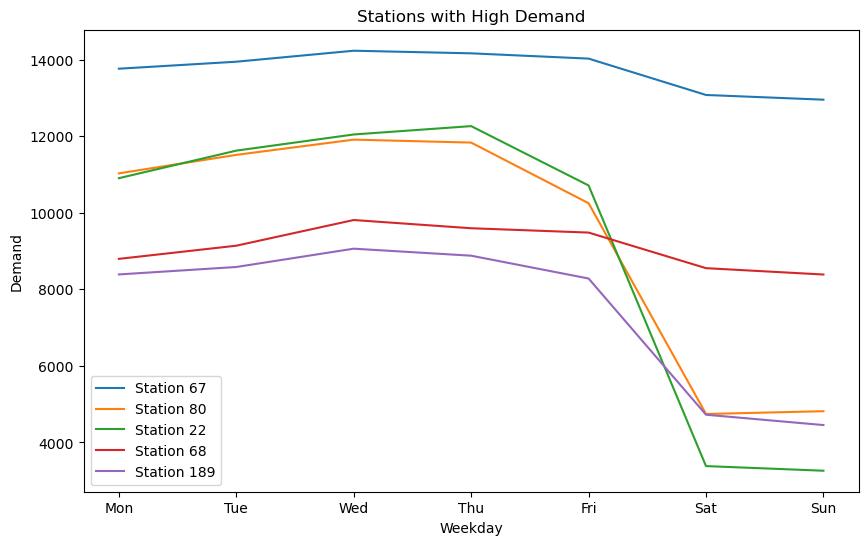

In [17]:
# Anzahl der Fahrradabholungen pro Station und Wochentag berechnen
demand = data.groupby(['start_station_id', 'weekday'])['bike_id'].count().reset_index()

# Stationen mit höchster Nachfrage ermitteln
high_demand_stations = demand.groupby('start_station_id')['bike_id'].sum().nlargest(5).index

# Nachfrage-Daten für die ausgewählten Stationen filtern
high_demand_data = demand[demand['start_station_id'].isin(high_demand_stations)]

# Nachfrage pro Wochentag für die ausgewählten Stationen visualisieren
plt.figure(figsize=(10, 6))
for station in high_demand_stations:
    station_data = high_demand_data[high_demand_data['start_station_id'] == station]
    plt.plot(station_data['weekday'], station_data['bike_id'], label=f"Station {station}")

plt.xlabel('Weekday')
plt.ylabel('Demand')
plt.title('Stations with High Demand')
plt.legend()
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

4. Stations with Low Availability: Identify stations that frequently run out of available bikes or have limited bike availability. This analysis can help determine if additional bikes need to be allocated to these stations or if adjustments are needed in bike redistribution strategies.

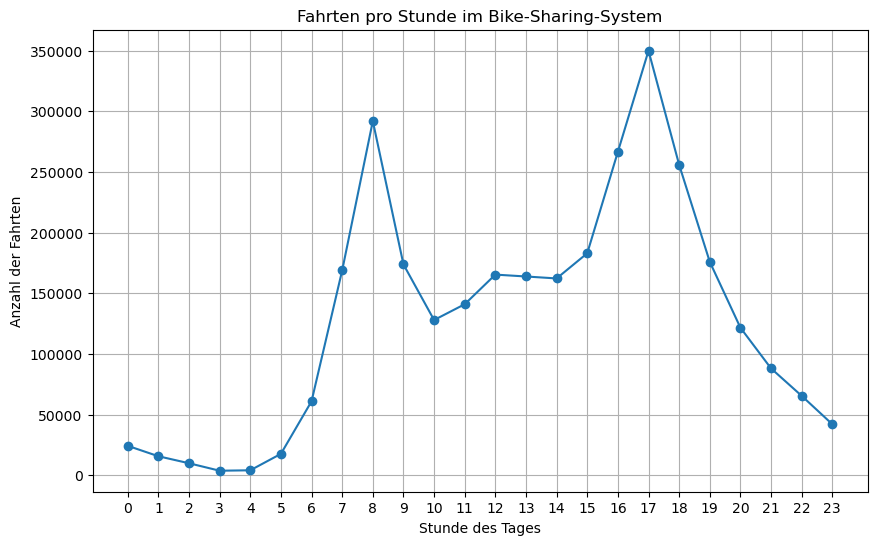

In [15]:
# Die Stunde aus der Startzeit extrahieren
data['start_hour'] = pd.to_datetime(data['start_time']).dt.hour

# Anzahl der Fahrten pro Stunde berechnen
hourly_counts = data['start_hour'].value_counts().sort_index()

# Diagramm der Fahrten pro Stunde anzeigen
plt.figure(figsize=(10, 6))
plt.plot(hourly_counts.index, hourly_counts.values, marker='o')
plt.xlabel('Stunde des Tages')
plt.ylabel('Anzahl der Fahrten')
plt.title('Fahrten pro Stunde im Bike-Sharing-System')
plt.xticks(range(24))
plt.grid(True)
plt.show()

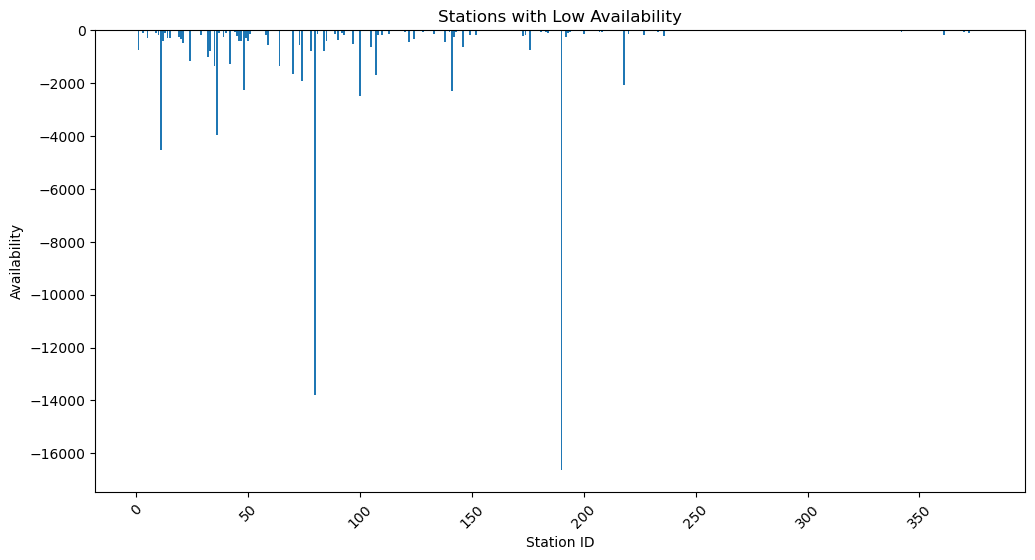

In [16]:
# Anzahl der Fahrradabholungen pro Station berechnen
pickup_counts = data['start_station_id'].value_counts()

# Anzahl der Fahrradrückgaben pro Station berechnen
dropoff_counts = data['end_station_id'].value_counts()

# Verfügbarkeit pro Station berechnen (Abholungen - Rückgaben)
availability = pickup_counts - dropoff_counts

# Stationen mit geringer Verfügbarkeit identifizieren
low_availability_stations = availability[availability < 0]

# Diagramm zur Verfügbarkeit der Stationen anzeigen
plt.figure(figsize=(12, 6))
plt.bar(low_availability_stations.index, low_availability_stations.values)
plt.xlabel('Station ID')
plt.ylabel('Availability')
plt.title('Stations with Low Availability')
plt.xticks(rotation=45)
plt.show()

5. Average Turnaround Time: Calculate the average time it takes for a bike to be returned to a station after being rented. This metric can help evaluate the efficiency of bike redistribution and identify stations with longer turnaround times that may require attention.

In [18]:
# Umkehrzeit berechnen (end_time - start_time)
data['turnaround_time'] = pd.to_datetime(data['end_time']) - pd.to_datetime(data['start_time'])

# Durchschnittliche Umkehrzeit berechnen
average_turnaround = data['turnaround_time'].mean()

# Ergebnis anzeigen
print("Durchschnittliche Umkehrzeit:", average_turnaround)

Durchschnittliche Umkehrzeit: 0 days 00:23:17.623741140


In [19]:
#Anzahl der Fahrten über einem bestimmten Schwellenwert: Sie können die Anzahl der Fahrten ermitteln, deren Umkehrzeit über einem bestimmten Schwellenwert liegt. Dadurch erhalten Sie Informationen über die Häufigkeit von Fahrten mit längeren Umkehrzeiten.

threshold = pd.Timedelta(minutes=30)  # Beispiel: Schwellenwert von 30 Minuten
trips_above_threshold = data[data['turnaround_time'] > threshold]
num_trips_above_threshold = len(trips_above_threshold)
print("Anzahl der Fahrten über dem Schwellenwert:", num_trips_above_threshold)


Anzahl der Fahrten über dem Schwellenwert: 287129


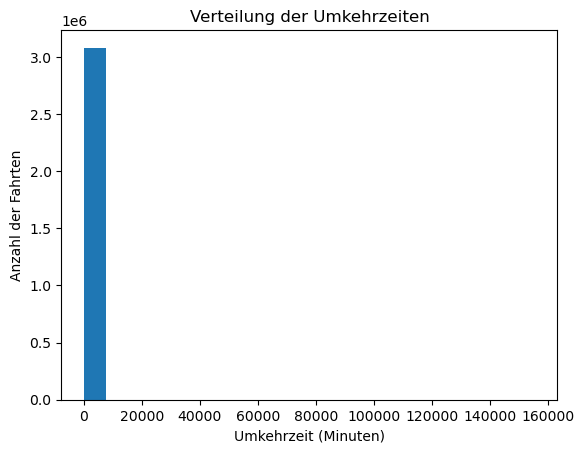

In [20]:
#Verteilung der Umkehrzeiten: Sie können die Verteilung der Umkehrzeiten visualisieren, um zu sehen, wie sich die Fahrten über verschiedene Zeitspannen erstrecken.

import matplotlib.pyplot as plt

plt.hist(data['turnaround_time'].dt.total_seconds() / 60, bins=20)
plt.xlabel('Umkehrzeit (Minuten)')
plt.ylabel('Anzahl der Fahrten')
plt.title('Verteilung der Umkehrzeiten')
plt.show()


In [21]:
#Durchschnittliche Umkehrzeit nach Station: Sie können die durchschnittliche Umkehrzeit für jede Station berechnen und vergleichen, um zu sehen, ob es Stationen gibt, die tendenziell längere oder kürzere Umkehrzeiten aufweisen.


avg_turnaround_by_station = data.groupby('start_station_id')['turnaround_time'].mean()
print(avg_turnaround_by_station)


start_station_id
1     0 days 00:53:37.741228070
3     0 days 00:24:44.923020189
4     0 days 00:27:06.114300464
5     0 days 00:16:51.707480934
6     0 days 00:22:10.877051205
                 ...           
373   0 days 00:23:28.333333333
374   0 days 00:26:29.441124780
376   0 days 00:19:14.552941176
377   0 days 00:13:12.271428571
378   0 days 00:15:26.140740740
Name: turnaround_time, Length: 313, dtype: timedelta64[ns]


6. Geographic Distribution: Analyze the geographic distribution of stations to ensure coverage across different neighborhoods or areas of the city. Identify any gaps or areas with limited station access to guide decisions on station placement or expansion.

In [25]:

# Gruppieren der Daten nach Stationen und Aggregation der geografischen Koordinaten
stations = data.groupby(['start_station_id'])[['start_station_lat', 'start_station_lon']].mean()

# Visualisierung der Stationen auf einer Karte
plt.figure(figsize=(10, 10))
plt.scatter(stations['start_station_lon'], stations['start_station_lat'], s=50, alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Bike Sharing Stations - Geographic Distribution')
plt.show()

KeyError: "Columns not found: 'start_station_lon', 'start_station_lat'"